In [1]:
import mlfinlab
import pandas as pd
import numpy as np
import yfinance as yf
from mlfinlab.portfolio_optimization.tic import TIC
from datetime import datetime, timedelta
import pypfopt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns,plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and (not y%100==0 or y%400 == 0) else 28,
        31,30,31,30,31,31,30,31,30,31][m-1])
    return date.replace(day=d,month=m, year=y)


END_DATE = datetime.today() - timedelta(days = 1) #END_DATE is set to yesterday


def tic_covariances(data_opt):
    
    #Country tree
    data2 = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Country":[115,115,115,125,125,125],
       "Structure":[1,1,1,1,1,1]}
    df2 = pd.DataFrame(data2)
    
    
    #Asset type tree
    data = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Asset Class":[215,225,235,215,225,235],
       "Structure":[2,2,2,2,2,2],}
    df = pd.DataFrame(data)
    
    stock_returns = expected_returns.mean_historical_return(data_opt)
    
    std_ticker = []
    for key in range(stock_returns.shape[0]):
        std_ticker.append(data_opt.iloc[:, key].std())
    corr_matrix = data_opt.corr()
    tn_relation = data_opt.shape[0] / data_opt.shape[1]
    
    tic = TIC()
    tic_matrix = pd.DataFrame(tic.tic_correlation(df, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance = tic.corr_dist(corr_matrix, tic_matrix)
    tic_cov = pypfopt.risk_models.corr_to_cov(tic_matrix,std_ticker)
    
    
    tic2 = TIC()
    tic_matrix_2 = pd.DataFrame(tic2.tic_correlation(df2, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance = tic2.corr_dist(corr_matrix, tic_matrix_2)
    tic_cov2 = pypfopt.risk_models.corr_to_cov(tic_matrix_2,std_ticker)
    
    big_tic = (tic_matrix+tic_matrix_2)/2
    big_tic_cov = pypfopt.risk_models.corr_to_cov(big_tic,std_ticker)
    
    empirical_covariance = risk_models.sample_cov(data_opt)
    
    return big_tic_cov, tic_cov, tic_cov2, empirical_covariance


In [2]:
def optimisation(data_opt, covariance):
    
    # Calculate the expected returns and covariance matrix based on that month
    mu = expected_returns.mean_historical_return(data_opt, frequency = len(data_opt))
    S = tic_covariances(data_opt)[covariance]

    # Optimise mean - variance to get weights for initialising investment process
    ef = EfficientFrontier(mu, S)
    #ef.add_objective(objective_functions.L2_reg, gamma = 1)
    raw_weights = ef.efficient_return(0.002)
    cleaned_weights = ef.clean_weights()
    return cleaned_weights, S


##Adjust to use interval variable
def fractional_profit(cleaned_weights, portfolio_tickers, portfolio_value_updated, i, start_date,data_opt,interval):
    j = 0
    new_data = yf.download(portfolio_tickers, monthdelta(start_date, i+interval), monthdelta(start_date, i+2*interval))
    new_data = new_data["Adj Close"]
    monthly_earnings = 0
    for key in cleaned_weights:
        monthly_earnings += cleaned_weights[key] * (portfolio_value_updated / get_latest_prices(data_opt)[j]) * (get_latest_prices(new_data)[j] -get_latest_prices(data_opt)[j])
        j+=1
    return monthly_earnings


def investment_simulation_1(portfolio_tickers, start_date, end_date, portfolio_value, covariance, TIC = False, interval=1):
    i = -interval
    portfolio_value_updated = portfolio_value
    total_profit = 0
    monthly_profit = 0
    timer = True
    cleaned_weights = {}
    profit_values = []
    month_values = []
    
    while timer:
        d =[]
        # Download data from month before the investment process starts (Adj close we consider to be the price for the day)
        data_opt = yf.download(" ".join(portfolio_tickers), monthdelta(start_date, i), monthdelta(start_date, i+interval))
        data_opt = data_opt["Adj Close"]
        try:
            cleaned_weights = optimisation(data_opt, covariance)[0]
        except:
            for element in portfolio_tickers:
                cleaned_weights[element] = 1/len(portfolio_tickers)
        #print(cleaned_weights)
       
        monthly_profit = fractional_profit(cleaned_weights," ".join(portfolio_tickers), portfolio_value_updated, i, start_date,data_opt,interval)
        #print("Profit of month " + str(i + interval) + " is " +str(monthly_profit))
        month_values.append((i + interval))
        profit_values.append((monthly_profit/portfolio_value)*100)
    
        
        portfolio_value_updated += monthly_profit
        i +=interval
        if monthdelta(start_date,i) == end_date:
            total_profit = portfolio_value_updated - portfolio_value
            timer = False
        cov = optimisation(data_opt, covariance)[1]
    return total_profit, profit_values, month_values, cov,

In [3]:
#covariance argument: 0 is for big_tic_cov, 1 is for asset type_covariance, 2 is for country_covariance, 3 is for empirical_covariance 

asset_universe = ["SPY", "LQD", "TLT", "0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"]

total_profits0, monthly_profits0, month0, covariance0 = investment_simulation_1(asset_universe,monthdelta(END_DATE,-13)
                        , monthdelta(END_DATE,-1),
                        1000000, 0, TIC = False, interval=1)
total_profits1, monthly_profits1, month1, covariance1 = investment_simulation_1(asset_universe,monthdelta(END_DATE,-13)
                        , monthdelta(END_DATE,-1),
                        1000000, 1, TIC = False, interval=1)
total_profits2, monthly_profits2, month2, covariance2 = investment_simulation_1(asset_universe,monthdelta(END_DATE,-13)
                        , monthdelta(END_DATE,-1),
                        1000000, 2, TIC = False, interval=1)
total_profits3, monthly_profits3, month3, covariance3 = investment_simulation_1(asset_universe,monthdelta(END_DATE,-13)
                        , monthdelta(END_DATE,-1),
                        1000000, 3, TIC = False, interval=1)

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%********

In [4]:

#This particular time enddate, start_date just happens to run from October to October
months_str = ['Oct 16th', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct 17th']


{3: '', 4: 'January', 5: 'February', 6: 'March', 7: 'April', 8: 'May', 9: 'June', 10: 'July', 11: 'August', 12: 'September', 1: 'October', 2: 'November'} [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


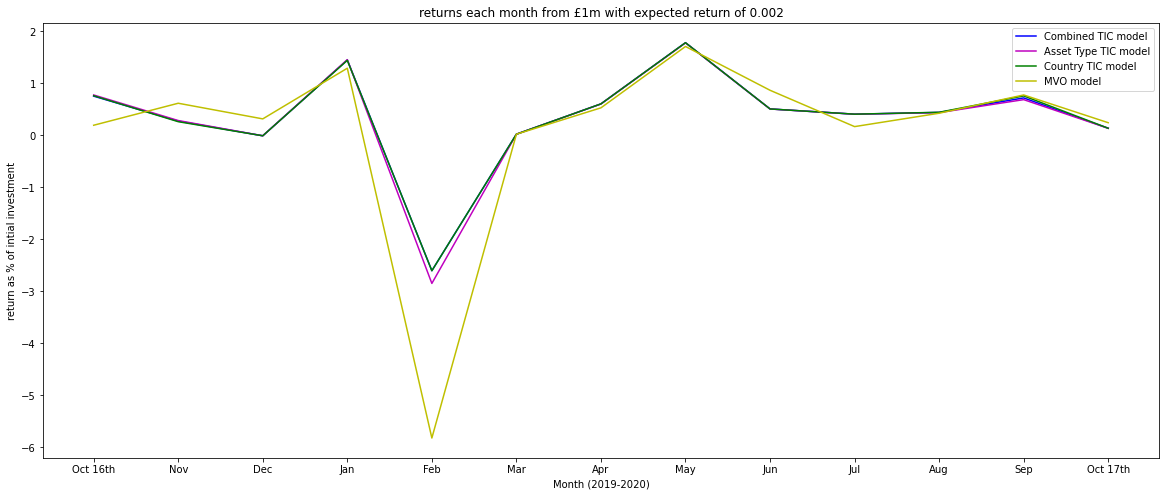

In [5]:
import matplotlib.pyplot as plt

#import calendar
#months = {1 + (i-10) % 12:calendar.month_name[i] for i in range(0, 12)}
#print(months, month0) #numbers correspond to month

plt.figure(figsize=(20, 8))
line0 = plt.plot(months_str, monthly_profits0, 'b', label='Combined TIC model')
line1 = plt.plot(months_str, monthly_profits1, 'm', label='Asset Type TIC model')
line2 = plt.plot(months_str, monthly_profits2, 'g', label='Country TIC model')
line3 = plt.plot(months_str, monthly_profits3, 'y', label='MVO model')
plt.title('returns each month from £1m with expected return of 0.002')
plt.xlabel('Month (2019-2020)')
plt.ylabel('return as % of intial investment')

plt.legend()
plt.show()

